In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

# titanic data

Najpierw zaloguj się do https://www.kaggle.com/ i przejdź do wyzwania https://www.kaggle.com/c/titanic, aby pobrać 
 * train.csv i test.csv. 

Zapisz je w katalogu datasets/titanic.

In [25]:
import os
TITANIC_PATH = os.path.join("datasets", "titanic")

In [26]:
# TITANIC_PATH = 'datasets\\titanic'

In [27]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [28]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

* Dane są już podzielone na zestaw treningowy i zestaw testów. 
* Jednak dane testowe nie zawierają etykiet: Twoim celem jest wyszkolenie najlepszego modelu, który możesz wykorzystać w danych treningowych, następnie dokonanie swoich przewidywań na danych testowych i przesłanie ich do Kaggle, aby zobaczyć ostateczny wynik.

Rzućmy okiem na kilka pierwszych rzędów zestawu treningowego:

In [29]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:

* Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* Pclass: passenger class.
* Name, Sex, Age: self-explanatory
* SibSp: how many siblings & spouses of the passenger aboard the Titanic.
* Parch: how many children & parents of the passenger aboard the Titanic.
* Ticket: ticket id
* Fare: price paid (in pounds)
* Cabin: passenger's cabin number
* Embarked: where the passenger embarked the Titanic
* Let's get more info to see how much data is missing:

In [30]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Atrybuty **Age**, **Cabin** oraz **Embarked** są czasami zerowe (mniej niż 891 wartości bez wartości null), szczególnie w przypadku **Cabin** (77% ma wartość zerową). Zignorujemy teraz **Cabin** i skupimy się na reszcie. Atrybut **Age** ma około 19% wartości pustych, więc będziemy musieli zdecydować, co z nimi zrobić. Zastąpienie wartości null medianą wieku wydaje się uzasadnione.

Atrybuty **Name** i **Ticket** mogą mieć pewną wartość, ale będą one nieco trudne do przekształcenia w użyteczne liczby. Na razie będziemy je ignorować.

Rzućmy okiem na atrybuty liczbowe:

In [31]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Tylko 38% przeżyło: to wystarczająco blisko do 40%, więc **accuracy** będzie rozsądną miarą do oceny naszego modelu.

Sprawdźmy, czy etykiety przyjmują wartości 0 lub 1:

Nie zapomnij o etykietach:

In [32]:
# y_train = 

X = train_data.drop(['Survived'], axis=1)
y = train_data['Survived'].values


from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print("X.shape: {} y.shape: {}".format(X.shape, y.shape))

X.shape: (891, 11) y.shape: (891,)


In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Teraz rzućmy okiem na wszystkie atrybuty kategoryczne:

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [35]:
from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer


num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [36]:
num_pipeline.fit_transform(X_train)

array([[ 45.5   ,   0.    ,   0.    ,  28.5   ],
       [ 23.    ,   0.    ,   0.    ,  13.    ],
       [ 32.    ,   0.    ,   0.    ,   7.925 ],
       ...,
       [ 41.    ,   2.    ,   0.    ,  14.1083],
       [ 14.    ,   1.    ,   2.    , 120.    ],
       [ 21.    ,   0.    ,   1.    ,  77.2875]])

Atrybut **Embarked** mówi nam, gdzie pasażer zaokrętował: C = Cherbourg, Q = Queenstown, S = Southampton.

Teraz zbudujmy nasze **pipeline** preprocessingu. 

Wykorzystamy DataframeSelector aby wybrać określone atrybuty z DataFrame:

In [37]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

Zbudujmy **pipeline** dla atrybutów numerycznych:

In [38]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Cabin", "Embarked", "Sex"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown = 'ignore')),
    ])

In [39]:
cat_pipeline.fit_transform(X_train)


array([[0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

Będziemy także potrzebować imputera do kategorycznych kolumn  napisowych (zwykły Imputer nie działa na tych kolumnach):

In [40]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [41]:
from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed,shuffle=True)

Teraz możemy zbudować **pipeline** dla atrybutów kategorycznych:

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(C=1, solver='newton-cg'))])


param_grid = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_1 = GridSearchCV(pipe, param_grid, cv=kfold)

grid_1.fit(X_train, y_train)
grid_1.best_params_

{'classifier__C': 0.1}

In [47]:
from sklearn.ensemble import RandomForestClassifier

pipe_2 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', RandomForestClassifier(n_estimators=500, max_leaf_nodes=16))
                  ])

param_grid_2 = {'classifier__n_estimators': [10, 50, 100],
              'classifier__max_leaf_nodes': [10, 20],
              'classifier__max_depth': [10, 20]
             }

grid_2 = GridSearchCV(pipe_2, param_grid_2, cv=kfold, return_train_score=True)

grid_2.fit(X_train, y_train)
grid_2.best_params_

{'classifier__max_depth': 10,
 'classifier__max_leaf_nodes': 10,
 'classifier__n_estimators': 10}

Na koniec połączmy powyższe podejścia:

In [58]:
pipe_3 = Pipeline([('preprocessing', preprocess_pipeline), ('classifier', SVC(C=1, probability=True))])

param_grid_3 = {
            'classifier__C': [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'classifier__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

grid_3 = GridSearchCV(pipe_3, param_grid_3, cv=kfold, return_train_score=True)

grid_3.fit(X_train, y_train)
grid_3.best_params_

{'classifier__C': 100, 'classifier__gamma': 0.001}

Teraz mamy fajny **pipeline** przetwarzania wstępnego, który pobiera dane wejściowe i zwraca dane wyjściowe złorzone z liczb, które możemy podać do dowolnego modelu uczenia maszynowego.

In [ ]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('grid1', grid_1.best_estimator_), 
                ('grid2', grid_2.best_estimator_), 
                ('grid3', grid_3.best_estimator_)], 
    voting='soft')
voting_clf.fit(X_train, y_train)

# Zad

Robimy StratifiedKFold i znajdujemy optymalne parametry dla

* SVM z jądrem rbf
* SVM z jądrem poly
* SVM liniowego
* Regresji logistycznej

In [59]:
from sklearn import  metrics


models = []
models.append(('LR', grid_1.best_estimator_))
models.append(('RF', grid_2.best_estimator_))
models.append(('SVM', grid_3.best_estimator_))

precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
auc_score = []

for name, model in models:
    print(name)
    print("precision_score: {}".format(metrics.precision_score(y_test, model.predict(X_test)) ))
    print("recall_score: {}".format( metrics.recall_score(y_test, model.predict(X_test)) ))
    print("f1_score: {}".format( metrics.f1_score(y_test, model.predict(X_test)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model.predict(X_test)) ))
    #############################################
    print("auc_score: {}".format( metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1]) ))
    auc_score.append( metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1]) )
    #############################################
    precision_score.append(metrics.precision_score(y_test, model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test, model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test, model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))

LR
precision_score: 0.7352941176470589
recall_score: 0.6756756756756757
f1_score: 0.7042253521126761
accuracy_score: 0.7653631284916201
auc_score: 0.8621621621621621
RF
precision_score: 0.7647058823529411
recall_score: 0.7027027027027027
f1_score: 0.7323943661971832
accuracy_score: 0.7877094972067039
auc_score: 0.8496138996138997
SVM
precision_score: 0.782608695652174
recall_score: 0.7297297297297297
f1_score: 0.7552447552447553
accuracy_score: 0.8044692737430168
auc_score: 0.8666666666666667


In [61]:
import pandas as pd
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score,
     'auc_score' : auc_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['LR', 'RF', 'SVM'])
df

,Method,precision_score,recall_score,f1_score,accuracy_score,auc_score
0,LR,0.735294,0.675676,0.704225,0.765363,0.862162
1,RF,0.764706,0.702703,0.732394,0.787709,0.849614
2,SVM,0.782609,0.729730,0.755245,0.804469,0.866667


LR
RF
SVM


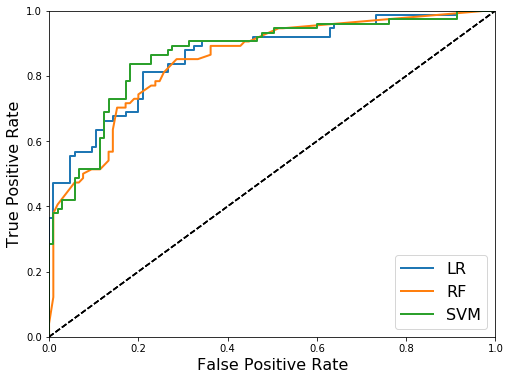

In [62]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
for name, model in models:
    print(name)
    if (name == 'SVM linear'):
        y_scores = model.decision_function(X_test)
    else: 
        y_scores = model.predict_proba(X_test)[:,1]        
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    plot_roc_curve(fpr, tpr, name)

plt.legend(loc="lower right", fontsize=16)
plt.show()
    